# Weather Data Analysis

###### This data analysis is using the complete data to gauge June 22 - July 6, 2021 on 15-minute intervals. This is to determine any missing data, outliers or incomplete data, extract important weather variables for traffic prediction, and make inferences on the weather factor of traffic prediction.

In [1]:
# change directory to parent folder to access all folders
import os
path = os.path.dirname(os.getcwd())
os.chdir(path)
from data_preprocessing.classes.load_traffic_data import Import_Traffic_Data

In [2]:
import pandas as pd 
import numpy as np 
from datetime import datetime, timedelta
import plotly.express as px
import ast
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib as mpl
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor

In [3]:
# References for data sources 
here_ref = "Data Source: Traffic data collected from HERE Traffic API. 6.2021."
tm_ref = "Data Source: Weather data collected from Tomorrow.io Weather API. 6.2021."

### Load weather data

In [4]:
# locate a random traffic file and load in using pandas
dir_wx = "/Users/lucadicarlo/Documents/OxfordBrookes/dissertation/development_of_traffic_model_for_Oxford/data_collection/data/wx_data/"
filename_wx = f"oxfordcity_wx_variables.csv"

# create datetime parser to deal with dates
mydateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ")

# load in csv
file_wx = pd.read_csv(dir_wx+filename_wx,parse_dates=["timestamp"],date_parser=mydateparser)

<ipython-input-4-d776b3b8192d>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  mydateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ")


### Preprocessing

Convert the 15-minute weather data to 5-minute weather data in order for both traffic and weather to be on the same temporal scale. Use linear interpolation.

In [5]:
# convert timestamp column to correct 15 minute intervals
file_wx.index = pd.to_datetime(file_wx.timestamp) + timedelta(minutes=1)

# upsample the data on 5-minute intervals
file_wx_5min = file_wx.resample("5Min").mean()

# for weather codes fill the times between codes with the previous value repeated
codes = file_wx_5min[['precipitationType','weatherCode']]
codes = codes.fillna(method="ffill")

# linearly interpolate the temporal data for the remainder of the variables
file_wx_int = file_wx_5min.interpolate()

# add the codes back into the dataframe
file_wx_int.precipitationType = codes.precipitationType
file_wx_int.weatherCode = codes.weatherCode

# select the time frame of interest (June 23 - July 6)
datetime_start=datetime(2021,6,23,0,0)
datetime_end=datetime(2021,7,13,10,50)
df_wx = file_wx_int[(file_wx_int.index >= datetime_start) & (file_wx_int.index <= datetime_end)]

In [6]:
# collect weather variables
time = pd.to_datetime(df_wx.index)
pi = df_wx.precipitationIntensity #mm/h
pt = df_wx.precipitationType # 0:NA / 1:Rain / 2:Snow / 3:Freezing Rain / 4:Ice Pellets
ws = df_wx.windSpeed #m/s
wg = df_wx.windGust # m/s
t = df_wx.temperature # C
h = df_wx.humidity #%
cc = df_wx.cloudCover #%
wx = df_wx.weatherCode

##### Save weather data on 5-min intervals

In [7]:
# save wx data on 5-min intervals
#df_wx.to_csv("data_collection/data/wx_data/oxfordcity_wx_variables_5min_intervals.csv")

### Analysis

In [8]:
df_wx.describe()

,precipitationIntensity,precipitationType,windSpeed,windGust,temperature,humidity,cloudCover,weatherCode
count,5891.00000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000
mean,0.09736,0.704295,3.048988,6.415068,15.725429,81.313549,49.404321,1778.287557
std,0.33976,0.456398,1.471222,2.970851,2.611042,12.526264,31.876454,1269.821554
min,0.00000,0.000000,0.120000,1.000000,6.310000,47.000000,0.000000,1000.000000
25%,0.00000,0.000000,1.870000,4.180000,13.870000,74.000000,20.333333,1100.000000
50%,0.00000,1.000000,3.000000,6.120000,15.433333,85.000000,49.666667,1100.000000
75%,0.01560,1.000000,4.000000,8.410000,17.620000,91.000000,79.000000,1102.000000
max,5.45310,1.000000,8.120000,16.870000,22.370000,99.000000,100.000000,4200.000000


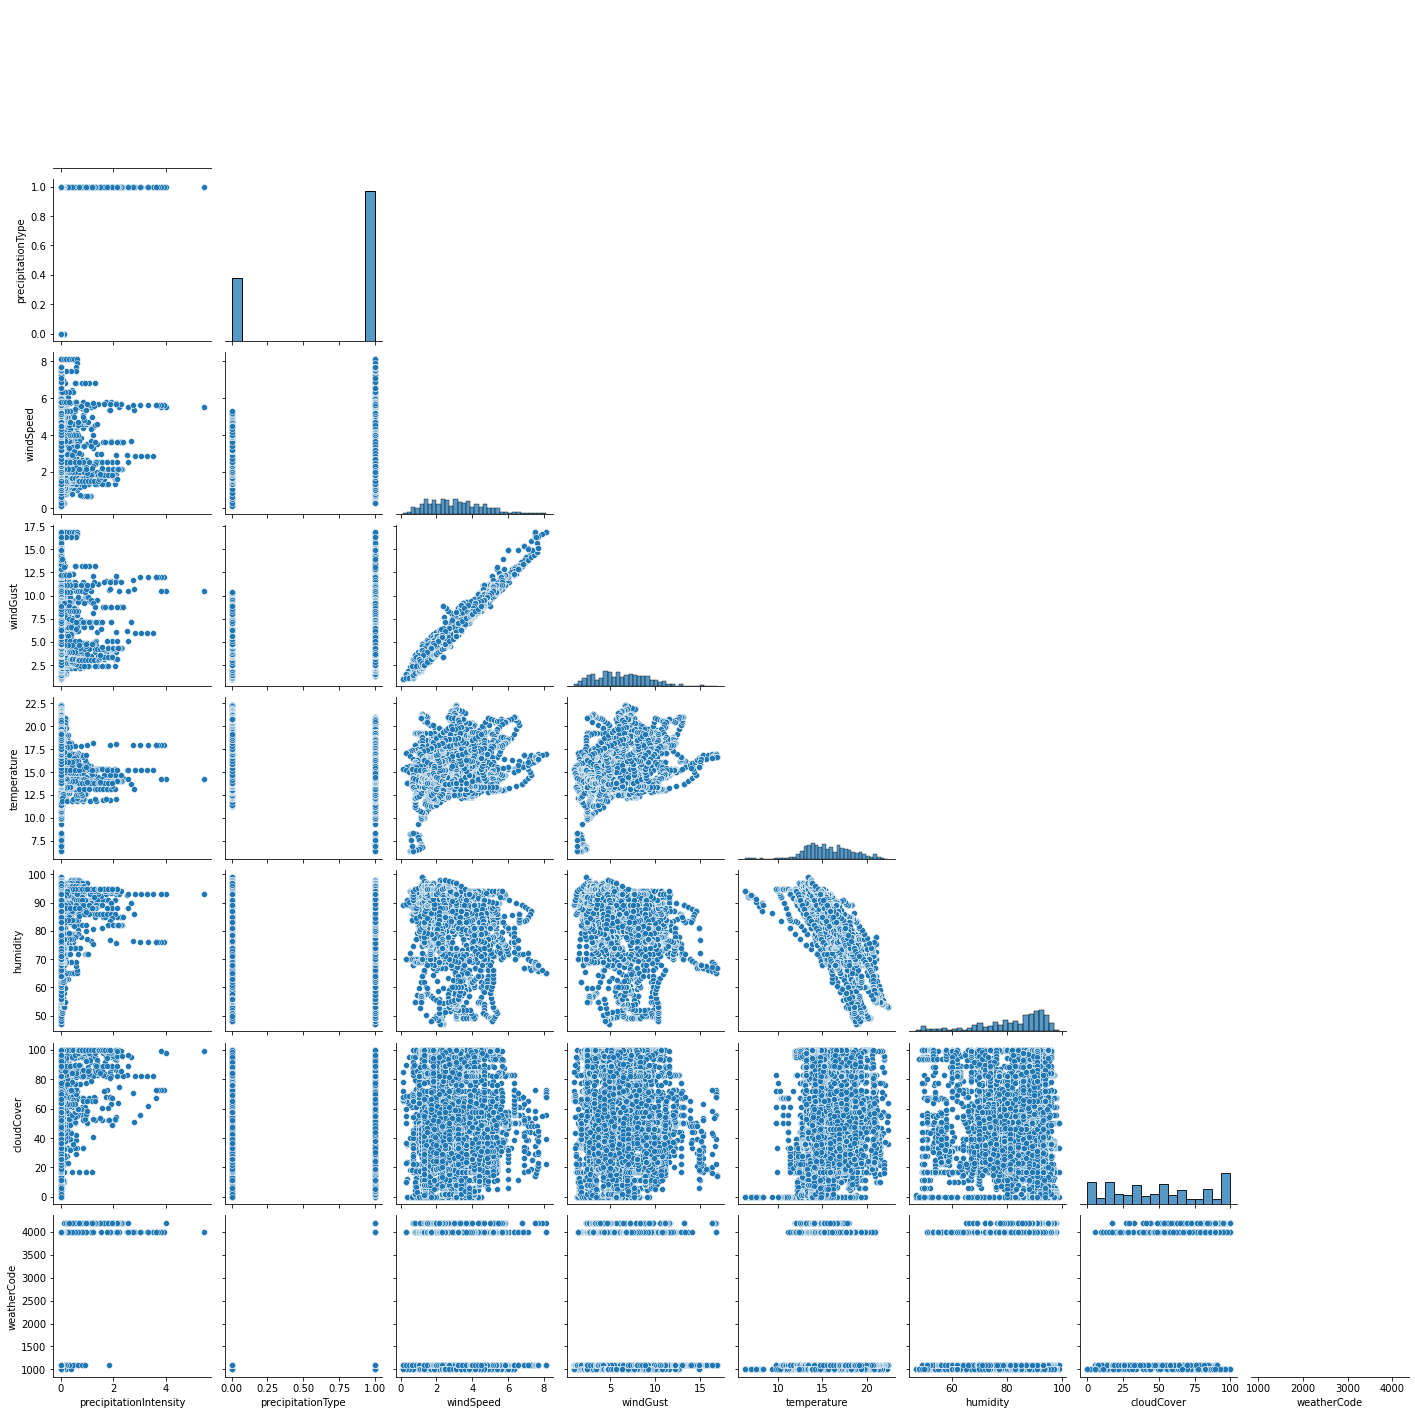

In [9]:
sns.pairplot(df_wx, corner=True, palette="rocket")
plt.savefig("figures/weather_variables_pairplot")

In [10]:
# weather codes dictionary
wx_codes_dict = {1000: "Clear", 1001: "Cloudy", 1100: "Mostly Clear",1101: "Partly Cloudy",1102: "Mostly Cloudy",2000: "Fog",
                 2100: "Light Fog",3000: "Light Wind",3001: "Wind",3002: "Strong Wind",4000: "Drizzle",4001: "Rain",4200: "Light Rain",
                 4201: "Heavy Rain",5000: "Snow",5001: "Flurries",5100: "Light Snow",5101: "Heavy Snow",6000: "Freezing Drizzle",
                 6001: "Freezing Rain",6200: "Light Freezing Rain",6201: "Heavy Freezing Rain",7000: "Ice Pellets",7101: "Heavy Ice Pellets",
                 7102: "Light Ice Pellets",8000: "Thunderstorm"}

# precipitation type dictionary
pt_dict = {0:"NA",1:"Rain",2:"Snow",3:"Freezing Rain", 4:"Ice Pellets"}

# collect wx codes from dictionary
wx_codes = [wx_codes_dict[code] for code in wx]
pt_codes = [pt_dict[code] for code in pt]

Descriptive statistics suggest normal ranges for the weather variables. 

Wind gusts & wind speed are highly correlated variables, which may result in removing one of the two in order to avoid multi-collinearity within the model. 



### Feature Selection

In [11]:
# Peartree roundabout bbox
top=51.798433
bottom=51.791451
right=-1.281979
left=-1.289524
datetime_start=datetime(2021,6,23,0,0)
datetime_end=datetime(2021,7,13,10,50)

traffic_data,time = Import_Traffic_Data(top,bottom,right,left).load_traffic_data(datetime_start,datetime_end)

The number of road segments within the area of interest is:  70
202106230000
202106230005
202106230010
202106230015
202106230020
202106230025
202106230030
202106230035
202106230040
202106230045
202106230050
202106230055
202106230100
202106230105
202106230110
202106230115
202106230120
202106230125
202106230130
202106230135
202106230140
202106230145
202106230150
202106230155
202106230200
202106230205
202106230210
202106230215
202106230220
202106230225
202106230230
202106230235
202106230240
202106230245
202106230250
202106230255
202106230300
202106230305
202106230310
202106230315
202106230320
202106230325
202106230330
202106230335
202106230340
202106230345
202106230350
202106230355
202106230400
202106230405
202106230410
202106230415
202106230420
202106230425
202106230430
202106230435
202106230440
202106230445
202106230450
202106230455
202106230500
202106230505
202106230510
202106230515
202106230520
202106230525
202106230530
202106230535
202106230540
202106230545
202106230550
202106230555


202106250510
202106250515
202106250520
202106250525
202106250530
202106250535
202106250540
202106250545
202106250550
202106250555
202106250600
202106250605
202106250610
202106250615
202106250620
202106250625
202106250630
202106250635
202106250640
202106250645
202106250650
202106250655
202106250700
202106250705
202106250710
202106250715
202106250720
202106250725
202106250730
202106250735
202106250740
202106250745
202106250750
202106250755
202106250800
202106250805
202106250810
202106250815
202106250820
202106250825
202106250830
202106250835
202106250840
202106250845
202106250850
202106250855
202106250900
202106250905
202106250910
202106250915
202106250920
202106250925
202106250930
202106250935
202106250940
202106250945
202106250950
202106250955
202106251000
202106251005
202106251010
202106251015
202106251020
202106251025
202106251030
202106251035
202106251040
202106251045
202106251050
202106251055
202106251100
202106251105
202106251110
202106251115
202106251120
202106251125
202106251130

202106271125
202106271130
202106271135
202106271140
202106271145
202106271150
202106271155
202106271200
202106271205
202106271210
202106271215
202106271220
202106271225
202106271230
202106271235
202106271240
202106271245
202106271250
202106271255
202106271300
202106271305
202106271310
202106271315
202106271320
202106271325
202106271330
202106271335
202106271340
202106271345
202106271350
202106271355
202106271400
202106271405
202106271410
202106271415
202106271420
202106271425
202106271430
202106271435
202106271440
202106271445
202106271450
202106271455
202106271500
202106271505
202106271510
202106271515
202106271520
202106271525
202106271530
202106271535
202106271540
202106271545
202106271550
202106271555
202106271600
202106271605
202106271610
202106271615
202106271620
202106271625
202106271630
202106271635
202106271640
202106271645
202106271650
202106271655
202106271700
202106271705
202106271710
202106271715
202106271720
202106271725
202106271730
202106271735
202106271740
202106271745

202106291725
202106291730
202106291735
202106291740
202106291745
202106291750
202106291755
202106291800
202106291805
202106291810
202106291815
202106291820
202106291825
202106291830
202106291835
202106291840
202106291845
202106291850
202106291855
202106291900
202106291905
202106291910
202106291915
202106291920
202106291925
202106291930
202106291935
202106291940
202106291945
202106291950
202106291955
202106292000
202106292005
202106292010
202106292015
202106292020
202106292025
202106292030
202106292035
202106292040
202106292045
202106292050
202106292055
202106292100
202106292105
202106292110
202106292115
202106292120
202106292125
202106292130
202106292135
202106292140
202106292145
202106292150
202106292155
202106292200
202106292205
202106292210
202106292215
202106292220
202106292225
202106292230
202106292235
202106292240
202106292245
202106292250
202106292255
202106292300
202106292305
202106292310
202106292315
202106292320
202106292325
202106292330
202106292335
202106292340
202106292345

202107012210
202107012215
202107012220
202107012225
202107012230
202107012235
202107012240
202107012245
202107012250
202107012255
202107012300
202107012305
202107012310
202107012315
202107012320
202107012325
202107012330
202107012335
202107012340
202107012345
202107012350
202107012355
202107020000
202107020005
202107020010
202107020015
202107020020
202107020025
202107020030
202107020035
202107020040
202107020045
202107020050
202107020055
202107020100
202107020105
202107020110
202107020115
202107020120
202107020125
202107020130
202107020135
202107020140
202107020145
202107020150
202107020155
202107020200
202107020205
202107020210
202107020215
202107020220
202107020225
202107020230
202107020235
202107020240
202107020245
202107020250
202107020255
202107020300
202107020305
202107020310
202107020315
202107020320
202107020325
202107020330
202107020335
202107020340
202107020345
202107020350
202107020355
202107020400
202107020405
202107020410
202107020415
202107020420
202107020425
202107020430

202107040345
202107040350
202107040355
202107040400
202107040405
202107040410
202107040415
202107040420
202107040425
202107040430
202107040435
202107040440
202107040445
202107040450
202107040455
202107040500
202107040505
202107040510
202107040515
202107040520
202107040525
202107040530
202107040535
202107040540
202107040545
202107040550
202107040555
202107040600
202107040605
202107040610
202107040615
202107040620
202107040625
202107040630
202107040635
202107040640
202107040645
202107040650
202107040655
202107040700
202107040705
202107040710
202107040715
202107040720
202107040725
202107040730
202107040735
202107040740
202107040745
202107040750
202107040755
202107040800
202107040805
202107040810
202107040815
202107040820
202107040825
202107040830
202107040835
202107040840
202107040845
202107040850
202107040855
202107040900
202107040905
202107040910
202107040915
202107040920
202107040925
202107040930
202107040935
202107040940
202107040945
202107040950
202107040955
202107041000
202107041005

202107060910
202107060915
202107060920
202107060925
202107060930
202107060935
202107060940
202107060945
202107060950
202107060955
202107061000
202107061005
202107061010
202107061015
202107061020
202107061025
202107061030
202107061035
202107061040
202107061045
202107061050
202107061055
202107061100
202107061105
202107061110
202107061115
202107061120
202107061125
202107061130
202107061135
202107061140
202107061145
202107061150
202107061155
202107061200
202107061205
202107061210
202107061215
202107061220
202107061225
202107061230
202107061235
202107061240
202107061245
202107061250
202107061255
202107061300
202107061305
202107061310
202107061315
202107061320
202107061325
202107061330
202107061335
202107061340
202107061345
202107061350
202107061355
202107061400
202107061405
202107061410
202107061415
202107061420
202107061425
202107061430
202107061435
202107061440
202107061445
202107061450
202107061455
202107061500
202107061505
202107061510
202107061515
202107061520
202107061525
202107061530

202107081350
202107081355
202107081400
202107081405
202107081410
202107081415
202107081420
202107081425
202107081430
202107081435
202107081440
202107081445
202107081450
202107081455
202107081500
202107081505
202107081510
202107081515
202107081520
202107081525
202107081530
202107081535
202107081540
202107081545
202107081550
202107081555
202107081600
202107081605
202107081610
202107081615
202107081620
202107081625
202107081630
202107081635
202107081640
202107081645
202107081650
202107081655
202107081700
202107081705
202107081710
202107081715
202107081720
202107081725
202107081730
202107081735
202107081740
202107081745
202107081750
202107081755
202107081800
202107081805
202107081810
202107081815
202107081820
202107081825
202107081830
202107081835
202107081840
202107081845
202107081850
202107081855
202107081900
202107081905
202107081910
202107081915
202107081920
202107081925
202107081930
202107081935
202107081940
202107081945
202107081950
202107081955
202107082000
202107082005
202107082010

202107101925
202107101930
202107101935
202107101940
202107101945
202107101950
202107101955
202107102000
202107102005
202107102010
202107102015
202107102020
202107102025
202107102030
202107102035
202107102040
202107102045
202107102050
202107102055
202107102100
202107102105
202107102110
202107102115
202107102120
202107102125
202107102130
202107102135
202107102140
202107102145
202107102150
202107102155
202107102200
202107102205
202107102210
202107102215
202107102220
202107102225
202107102230
202107102235
202107102240
202107102245
202107102250
202107102255
202107102300
202107102305
202107102310
202107102315
202107102320
202107102325
202107102330
202107102335
202107102340
202107102345
202107102350
202107102355
202107110000
202107110005
202107110010
202107110015
202107110020
202107110025
202107110030
202107110035
202107110040
202107110045
202107110050
202107110055
202107110100
202107110105
202107110110
202107110115
202107110120
202107110125
202107110130
202107110135
202107110140
202107110145

202107130035
202107130040
202107130045
202107130050
202107130055
202107130100
202107130105
202107130110
202107130115
202107130120
202107130125
202107130130
202107130135
202107130140
202107130145
202107130150
202107130155
202107130200
202107130205
202107130210
202107130215
202107130220
202107130225
202107130230
202107130235
202107130240
202107130245
202107130250
202107130255
202107130300
202107130305
202107130310
202107130315
202107130320
202107130325
202107130330
202107130335
202107130340
202107130345
202107130350
202107130355
202107130400
202107130405
202107130410
202107130415
202107130420
202107130425
202107130430
202107130435
202107130440
202107130445
202107130450
202107130455
202107130500
202107130505
202107130510
202107130515
202107130520
202107130525
202107130530
202107130535
202107130540
202107130545
202107130550
202107130555
202107130600
202107130605
202107130610
202107130615
202107130620
202107130625
202107130630
202107130635
202107130640
202107130645
202107130650
202107130655

In [12]:
# collect the average speed for all of the road network
sp_peartree = traffic_data[:,:,5].mean(axis=1)

# add the speed to the dataframe
df_wx["sp"] = pd.to_numeric(sp_peartree)

<ipython-input-12-7928f27e6b59>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wx["sp"] = pd.to_numeric(sp_peartree)


###### Linear Regression

In [13]:
X = df_wx.iloc[:,:8]
Y = df_wx.iloc[:, -1]

In [14]:
mod = smf.ols(formula='sp ~ precipitationIntensity + temperature + humidity  + weatherCode', data=df_wx)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     sp   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     730.8
Date:                Fri, 03 Sep 2021   Prob (F-statistic):               0.00
Time:                        12:21:32   Log-Likelihood:                -17012.
No. Observations:                5891   AIC:                         3.403e+04
Df Residuals:                    5886   BIC:                         3.407e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 42

The influence of weather variables is not high (r-square = 0.33) however it is statistically significant. 

Wind gust was removed due to high correlation, and so were other variables that were insignificant (p-value < 0.05).



##### Random Forest

In [15]:
# initialize random forest
rf = RandomForestRegressor(n_estimators=500)
model = rf.fit(X,Y)


Text(0.65, 0.15, 'Data Source: Traffic data collected from HERE Traffic API. 6.2021.')

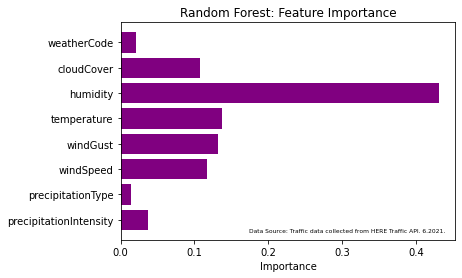

In [16]:
plt.barh(X.columns, model.feature_importances_,color="purple")
plt.xlabel("Importance")
plt.title("Random Forest: Feature Importance")
plt.figtext(0.65, 0.15, here_ref, ha="center", fontsize=6,)


###### Visualization of features

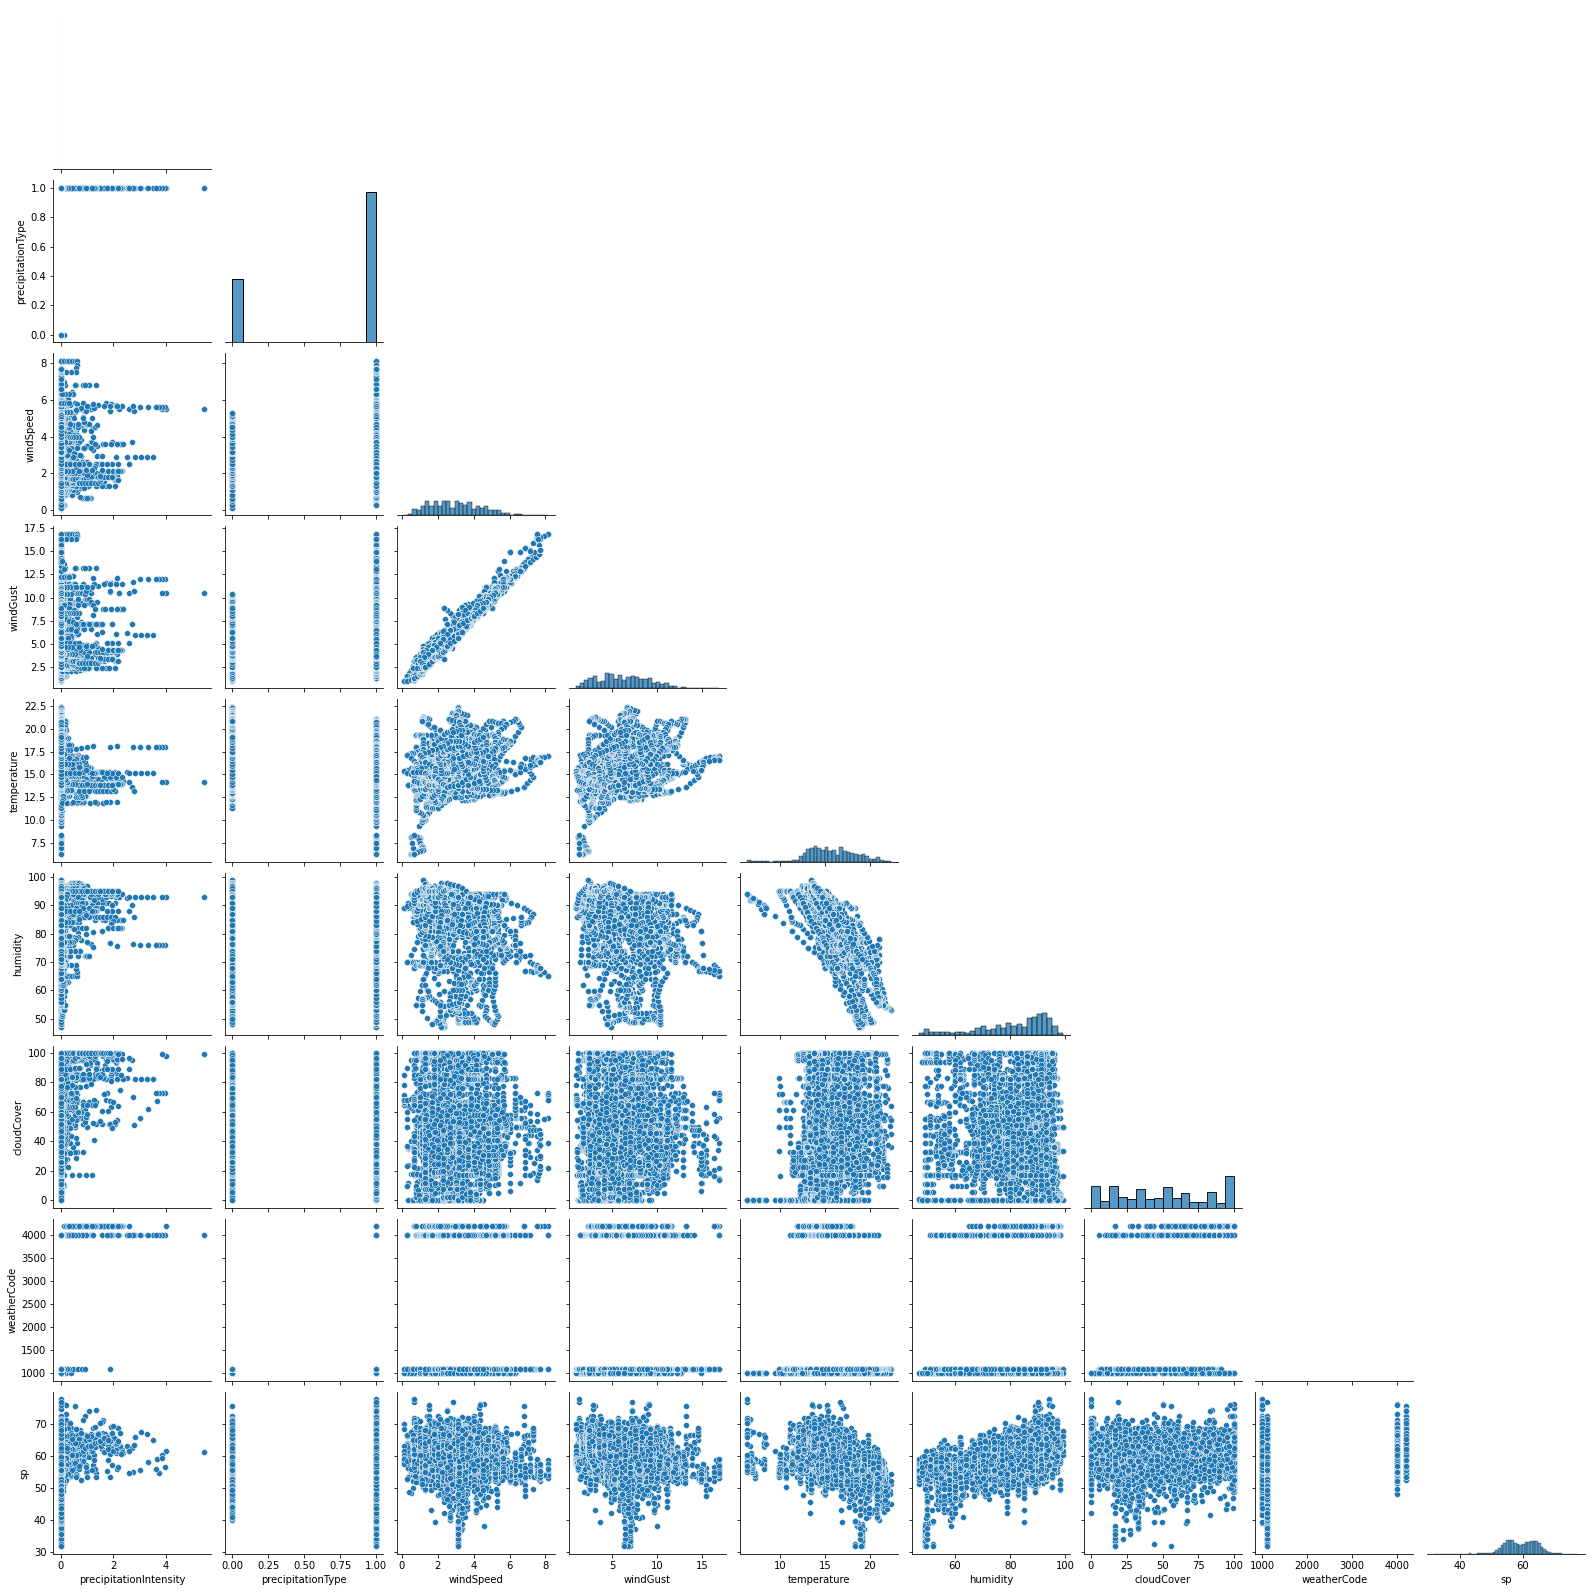

In [17]:
sns.pairplot(df_wx, corner=True )
plt.savefig("figures/weather_variables_pairplot")

There is a clear relationship between humidity and traffic speed, as humidity increases so does traffic speed. Higher temperatures also corresponds to lower traffic speeds.

The linear regression highlighted 5 variables of importance: precip type, precip intensity, humidity, temperature, and weather code.

Precipitation type is only between 0 and 1 however, and therefore adds no meaningful information to predicting traffic speeds. Therefore, we have four features that can be included within the model:

temperature

humidity

precipitation intensity

weather code

Text(0.5, 0.98, 'Correlation Plots of Weather Variables Against Traffic Speed')

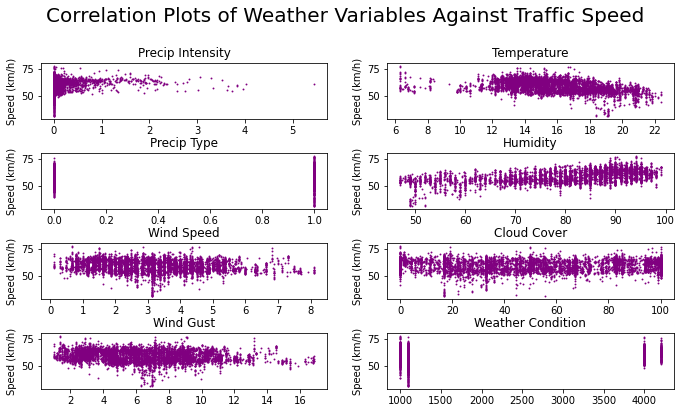

In [67]:
# Create subplots of correlations
fig, axs = plt.subplots(4, 2)
fig.tight_layout(h_pad=0.5, w_pad=0.5)
fig.set_size_inches(10, 6)
fig.subplots_adjust(top=0.85)
axs[0, 0].scatter(df_wx.precipitationIntensity, df_wx.sp,s=0.8,color="purple")
axs[0, 0].set_title('Precip Intensity')
axs[1, 0].scatter(df_wx.precipitationType, df_wx.sp,s=0.8,color="purple")
axs[1, 0].set_title('Precip Type')
axs[2, 0].scatter(df_wx.windSpeed, df_wx.sp,s=0.8,color="purple")
axs[2, 0].set_title('Wind Speed')
axs[3, 0].scatter(df_wx.windGust, df_wx.sp,s=0.8,color="purple")
axs[3, 0].set_title('Wind Gust')
axs[0, 1].scatter(df_wx.temperature, df_wx.sp,s=0.8,color="purple")
axs[0, 1].set_title('Temperature')
axs[1, 1].scatter(df_wx.humidity, df_wx.sp,s=0.8,color="purple")
axs[1, 1].set_title('Humidity')
axs[2, 1].scatter(df_wx.cloudCover, df_wx.sp,s=0.8,color="purple")
axs[2, 1].set_title('Cloud Cover')
axs[3, 1].scatter(df_wx.weatherCode, df_wx.sp,s=0.8,color="purple")
axs[3, 1].set_title('Weather Condition')


for ax in axs.flat:
    ax.set(xlabel='', ylabel='Speed (km/h)')
fig.suptitle("Correlation Plots of Weather Variables Against Traffic Speed",fontsize=20)